In [1]:
from utils import (
    sigfit,
    TwoFlashesProcessingStrategy_Explore,
)

import matplotlib.pyplot as plt
import numpy as np

## Parameters sweep

In [2]:
from skneuromsi.neural import Paredes2022
from skneuromsi.sweep import ParameterSweep

soas = np.linspace(36, 204, 15)


def two_flashes_job_explore(
    l_ex=0.5,
    cm_weight=1.036e-03,
    fb_weight=6.231e-01,
    ff_weight=3.892e00,
    ff_pruning_threshold=0,
    cm_pruning_threshold=0,
):

    model = Paredes2022(
        time_range=(0, 600),
        neurons=30,
        position_range=(0, 30),
        tau=(6.560e00, 9.191e00, 1.200e02),
    )

    sp = ParameterSweep(
        model=model,
        target="auditory_soa",
        repeat=1,
        n_jobs=10,
        range=soas,
        processing_strategy=TwoFlashesProcessingStrategy_Explore(),
    )

    res = sp.run(
        auditory_intensity=2.325,
        visual_intensity=1.45,
        auditory_stim_n=2,
        visual_stim_n=1,
        auditory_duration=7,
        visual_duration=12,
        noise=False,
        lateral_excitation=l_ex,
        lateral_inhibition=0.4,
        cross_modal_weight=cm_weight,
        feedback_weight=fb_weight,
        feedforward_weight=ff_weight,
        feedforward_pruning_threshold=ff_pruning_threshold,
        cross_modal_pruning_threshold=cm_pruning_threshold,
        causes_kind="prob",
        causes_dim="time",
    )

    return res

#### Lateral excitation

In [3]:
lex_values = np.linspace(0.5, 0.65, 7)

raw_model_data_per_lex = []
tbw_per_lex = []
causes_per_lex = []
opi_per_lex = []

for lex in lex_values:
    _, two_flashes_res, causes_res = two_flashes_job_explore(l_ex=lex)
    raw_model_data_per_lex.append(two_flashes_res)
    a, b, tbw, d = sigfit(soas, two_flashes_res)
    tbw_per_lex.append(tbw)
    p_causes_average = np.average(causes_res)
    causes_per_lex.append(p_causes_average)
    opi = np.average(two_flashes_res)
    opi_per_lex.append(opi)

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Text(0.5, 0, 'L_ex')

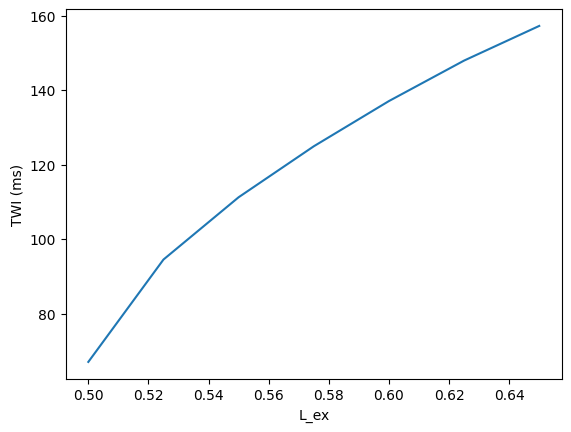

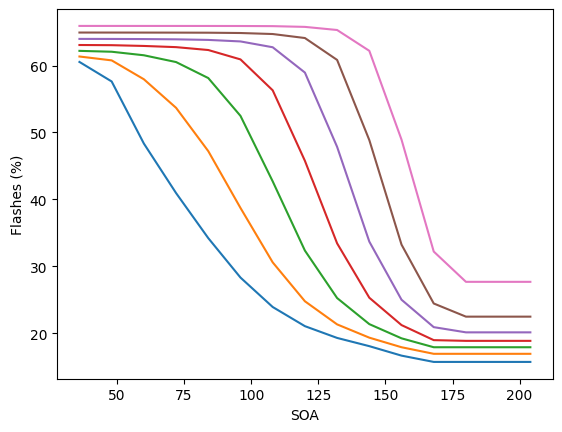

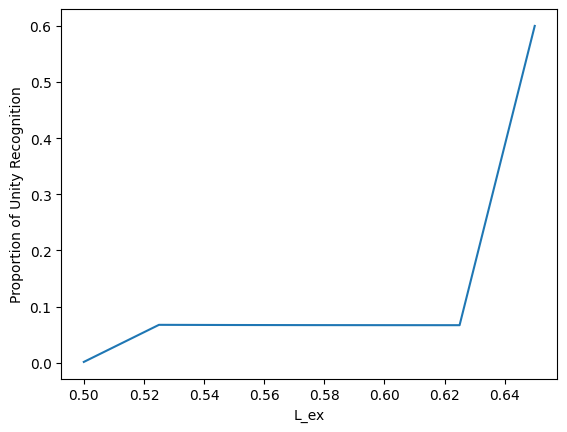

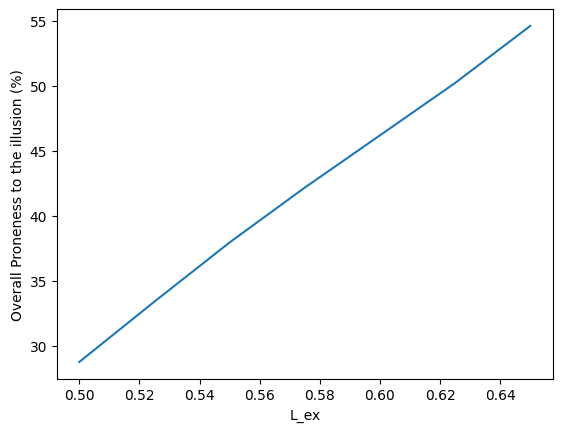

In [4]:
plt.figure(1)
plt.plot(lex_values, tbw_per_lex)
plt.ylabel("TWI (ms)")
plt.xlabel("L_ex")

plt.figure(2)
plt.plot(soas, np.array(raw_model_data_per_lex).T)
plt.ylabel("Flashes (%)")
plt.xlabel("SOA")

plt.figure(3)
plt.plot(lex_values, causes_per_lex)
plt.ylabel("Proportion of Unity Recognition")
plt.xlabel("L_ex")
# plt.ylim(0,1)

plt.figure(4)
plt.plot(lex_values, opi_per_lex)
plt.ylabel("Overall Proneness to the illusion (%)")
plt.xlabel("L_ex")

#### Feedback weight

In [9]:
fb_weight_values = np.linspace(0.60, 0.64, 7)  # 61-63

raw_model_data_per_fb_weight = []
tbw_per_fb_weight = []
causes_per_fb_weight = []
opi_per_fb_weight = []

for fb_weight in fb_weight_values:
    _, two_flashes_res, causes_res = two_flashes_job_explore(fb_weight=fb_weight)
    raw_model_data_per_fb_weight.append(two_flashes_res)
    a, b, tbw, d = sigfit(soas, two_flashes_res)
    tbw_per_fb_weight.append(tbw)
    p_causes_average = np.average(causes_res)
    causes_per_fb_weight.append(p_causes_average)
    opi = np.average(two_flashes_res)
    opi_per_fb_weight.append(opi)

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Text(0.5, 0, 'FB_weight')

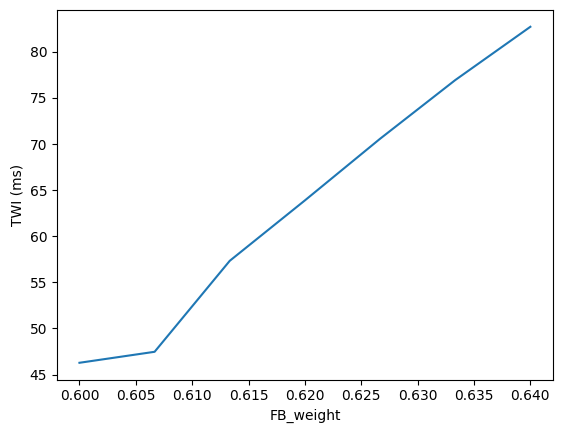

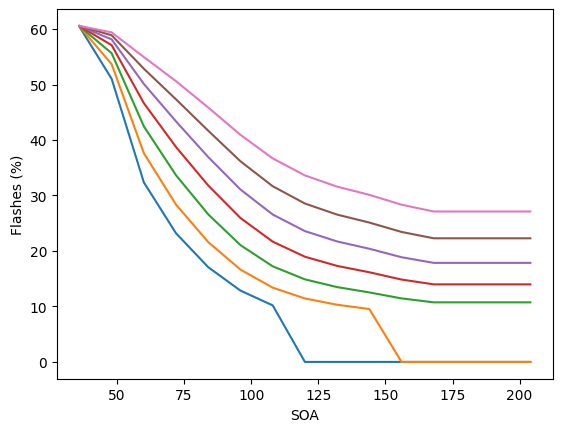

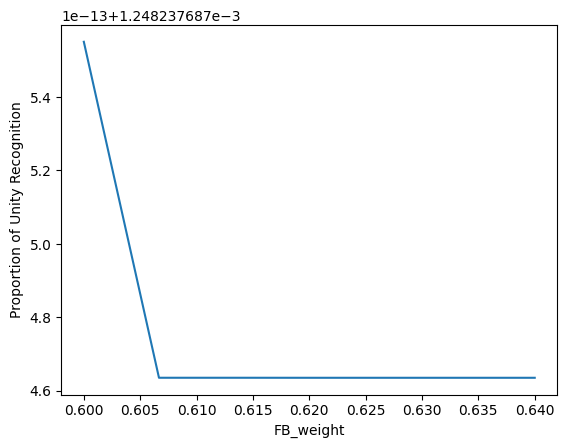

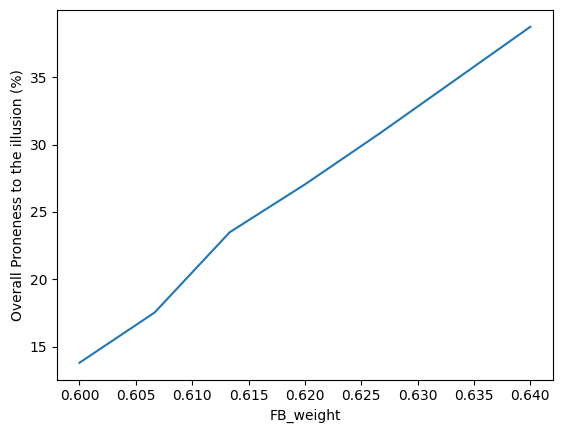

In [13]:
plt.figure(1)
plt.plot(fb_weight_values, tbw_per_fb_weight)
plt.ylabel("TWI (ms)")
plt.xlabel("FB_weight")

plt.figure(2)
plt.plot(soas, np.array(raw_model_data_per_fb_weight).T)
plt.ylabel("Flashes (%)")
plt.xlabel("SOA")

plt.figure(3)
plt.plot(fb_weight_values, causes_per_fb_weight)
plt.ylabel("Proportion of Unity Recognition")
plt.xlabel("FB_weight")

plt.figure(4)
plt.plot(fb_weight_values, opi_per_fb_weight)
plt.ylabel("Overall Proneness to the illusion (%)")
plt.xlabel("FB_weight")

## Cross-modal weight

In [8]:
cm_weight_values = np.linspace(0, 0.05, 7)

raw_model_data_per_cm_weight = []
tbw_per_cm_weight = []
causes_per_cm_weight = []
opi_per_cm_weight = []

for cm_weight in cm_weight_values:
    _, two_flashes_res, causes_res = two_flashes_job_explore(cm_weight=cm_weight)
    raw_model_data_per_cm_weight.append(two_flashes_res)
    a, b, tbw, d = sigfit(soas, two_flashes_res)
    tbw_per_cm_weight.append(tbw)
    p_causes_average = np.average(causes_res)
    causes_per_cm_weight.append(p_causes_average)
    opi = np.average(two_flashes_res)
    opi_per_cm_weight.append(opi)

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Text(0.5, 0, 'CM_weight')

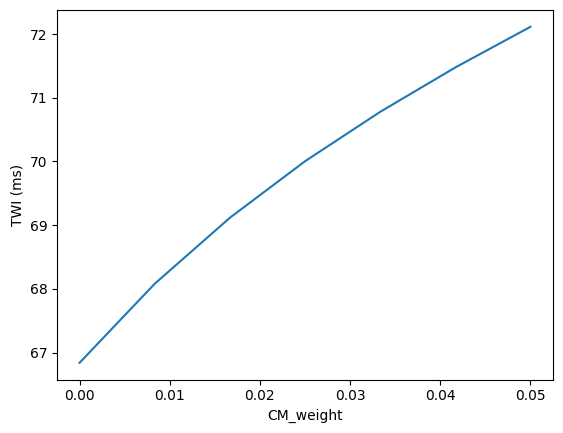

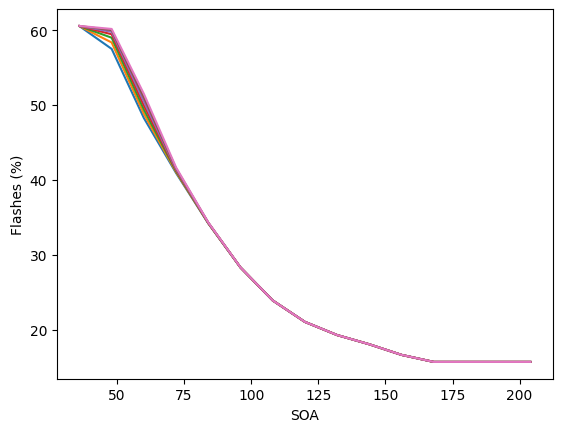

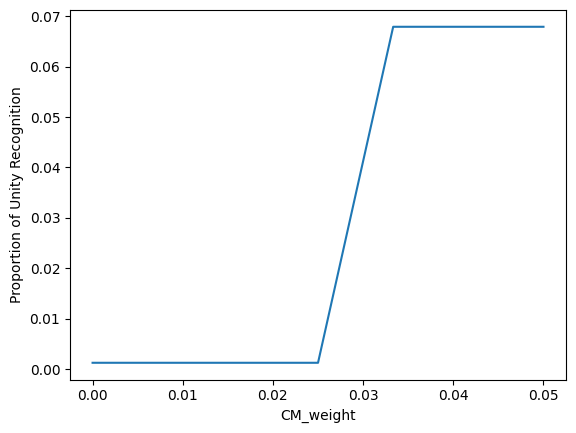

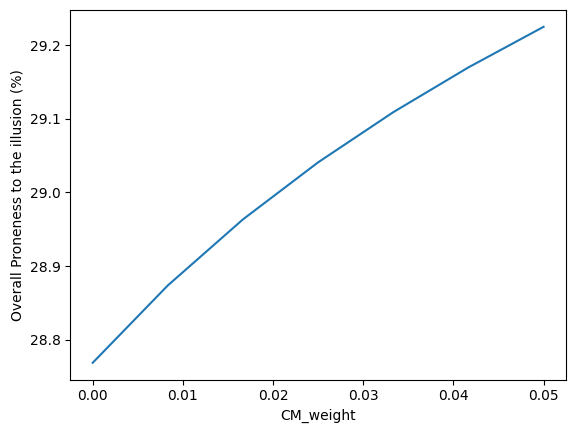

In [15]:
plt.figure(1)
plt.plot(cm_weight_values, tbw_per_cm_weight)
plt.ylabel("TWI (ms)")
plt.xlabel("CM_weight")

plt.figure(2)
plt.plot(soas, np.array(raw_model_data_per_cm_weight).T)
plt.ylabel("Flashes (%)")
plt.xlabel("SOA")

plt.figure(3)
plt.plot(cm_weight_values, causes_per_cm_weight)
plt.ylabel("Proportion of Unity Recognition")
plt.xlabel("CM_weight")

plt.figure(4)
plt.plot(cm_weight_values, opi_per_cm_weight)
plt.ylabel("Overall Proneness to the illusion (%)")
plt.xlabel("CM_weight")

## Feedforward pruning

In [5]:
ff_pruning_values = np.linspace(0, 3.892e00, 7)

raw_model_data_per_ff_pruning = []
tbw_per_ff_pruning = []
causes_per_ff_pruning = []
opi_per_ff_pruning = []

for ff_pruning in ff_pruning_values:
    _, two_flashes_res, causes_res = two_flashes_job_explore(
        ff_pruning_threshold=ff_pruning
    )
    raw_model_data_per_ff_pruning.append(two_flashes_res)
    a, b, tbw, d = sigfit(soas, two_flashes_res)
    tbw_per_ff_pruning.append(tbw)
    p_causes_average = np.average(causes_res)
    causes_per_ff_pruning.append(p_causes_average)
    opi = np.average(two_flashes_res)
    opi_per_ff_pruning.append(opi)

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Text(0.5, 0, 'Feedforward Pruning')

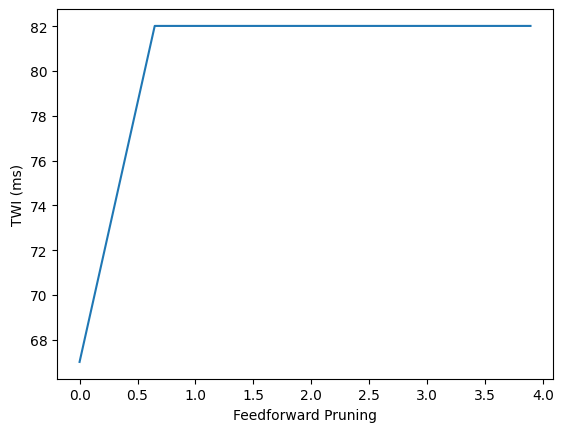

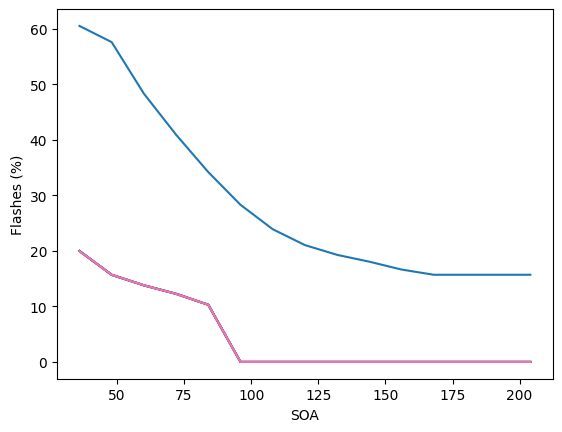

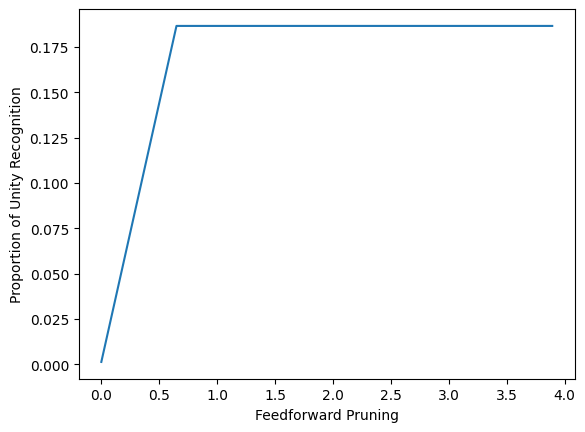

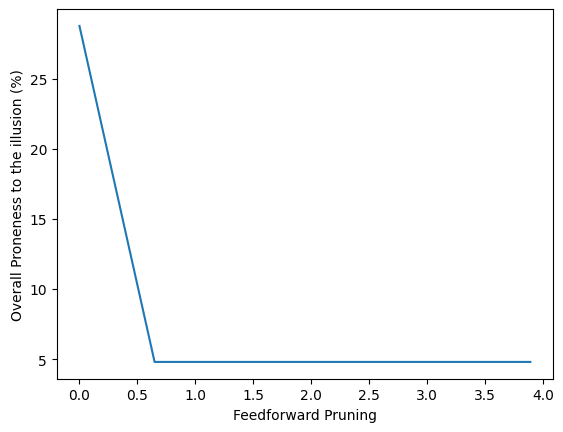

In [6]:
plt.figure(1)
plt.plot(ff_pruning_values, tbw_per_ff_pruning)
plt.ylabel("TWI (ms)")
plt.xlabel("Feedforward Pruning")

plt.figure(2)
plt.plot(soas, np.array(raw_model_data_per_ff_pruning).T)
plt.ylabel("Flashes (%)")
plt.xlabel("SOA")

plt.figure(3)
plt.plot(ff_pruning_values, causes_per_ff_pruning)
plt.ylabel("Proportion of Unity Recognition")
plt.xlabel("Feedforward Pruning")

plt.figure(4)
plt.plot(ff_pruning_values, opi_per_ff_pruning)
plt.ylabel("Overall Proneness to the illusion (%)")
plt.xlabel("Feedforward Pruning")

In [7]:
cm_pruning_values = np.linspace(0, 1.036e-03, 7)

raw_model_data_per_cm_pruning = []
tbw_per_cm_pruning = []
causes_per_cm_pruning = []
opi_per_cm_pruning = []

for cm_pruning in cm_pruning_values:
    _, two_flashes_res, causes_res = two_flashes_job_explore(
        cm_pruning_threshold=cm_pruning
    )
    raw_model_data_per_cm_pruning.append(two_flashes_res)
    a, b, tbw, d = sigfit(soas, two_flashes_res)
    tbw_per_cm_pruning.append(tbw)
    p_causes_average = np.average(causes_res)
    causes_per_cm_pruning.append(p_causes_average)
    opi = np.average(two_flashes_res)
    opi_per_cm_pruning.append(opi)

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Text(0.5, 0, 'Cross-modal Pruning')

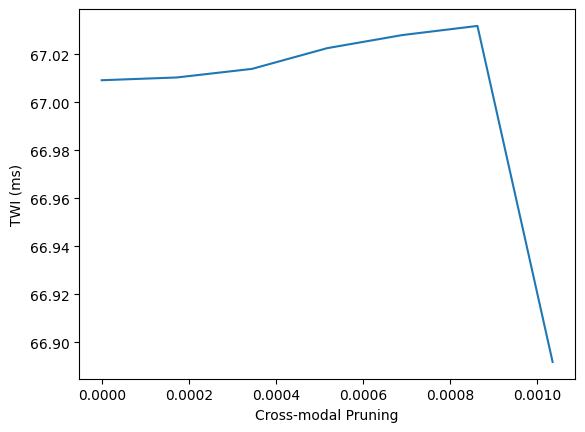

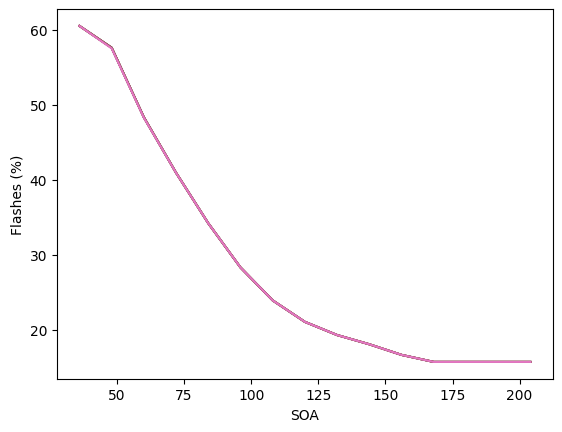

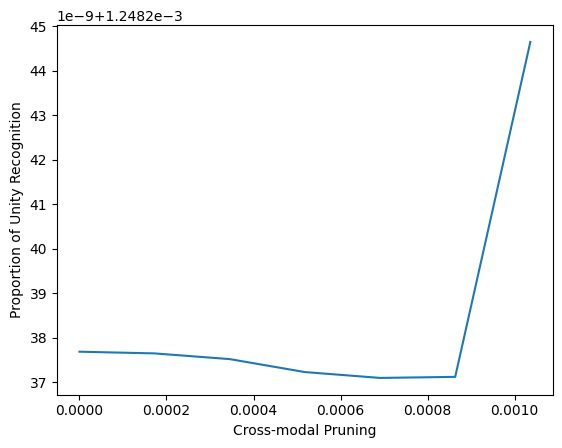

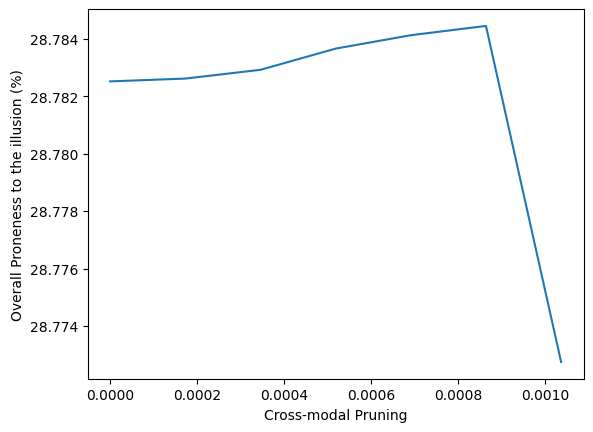

In [17]:
plt.figure(1)
plt.plot(cm_pruning_values, tbw_per_cm_pruning)
plt.ylabel("TWI (ms)")
plt.xlabel("Cross-modal Pruning")

plt.figure(2)
plt.plot(soas, np.array(raw_model_data_per_cm_pruning).T)
plt.ylabel("Flashes (%)")
plt.xlabel("SOA")

plt.figure(3)
plt.plot(cm_pruning_values, causes_per_cm_pruning)
plt.ylabel("Proportion of Unity Recognition")
plt.xlabel("Cross-modal Pruning")

plt.figure(4)
plt.plot(cm_pruning_values, opi_per_cm_pruning)
plt.ylabel("Overall Proneness to the illusion (%)")
plt.xlabel("Cross-modal Pruning")

# Plot

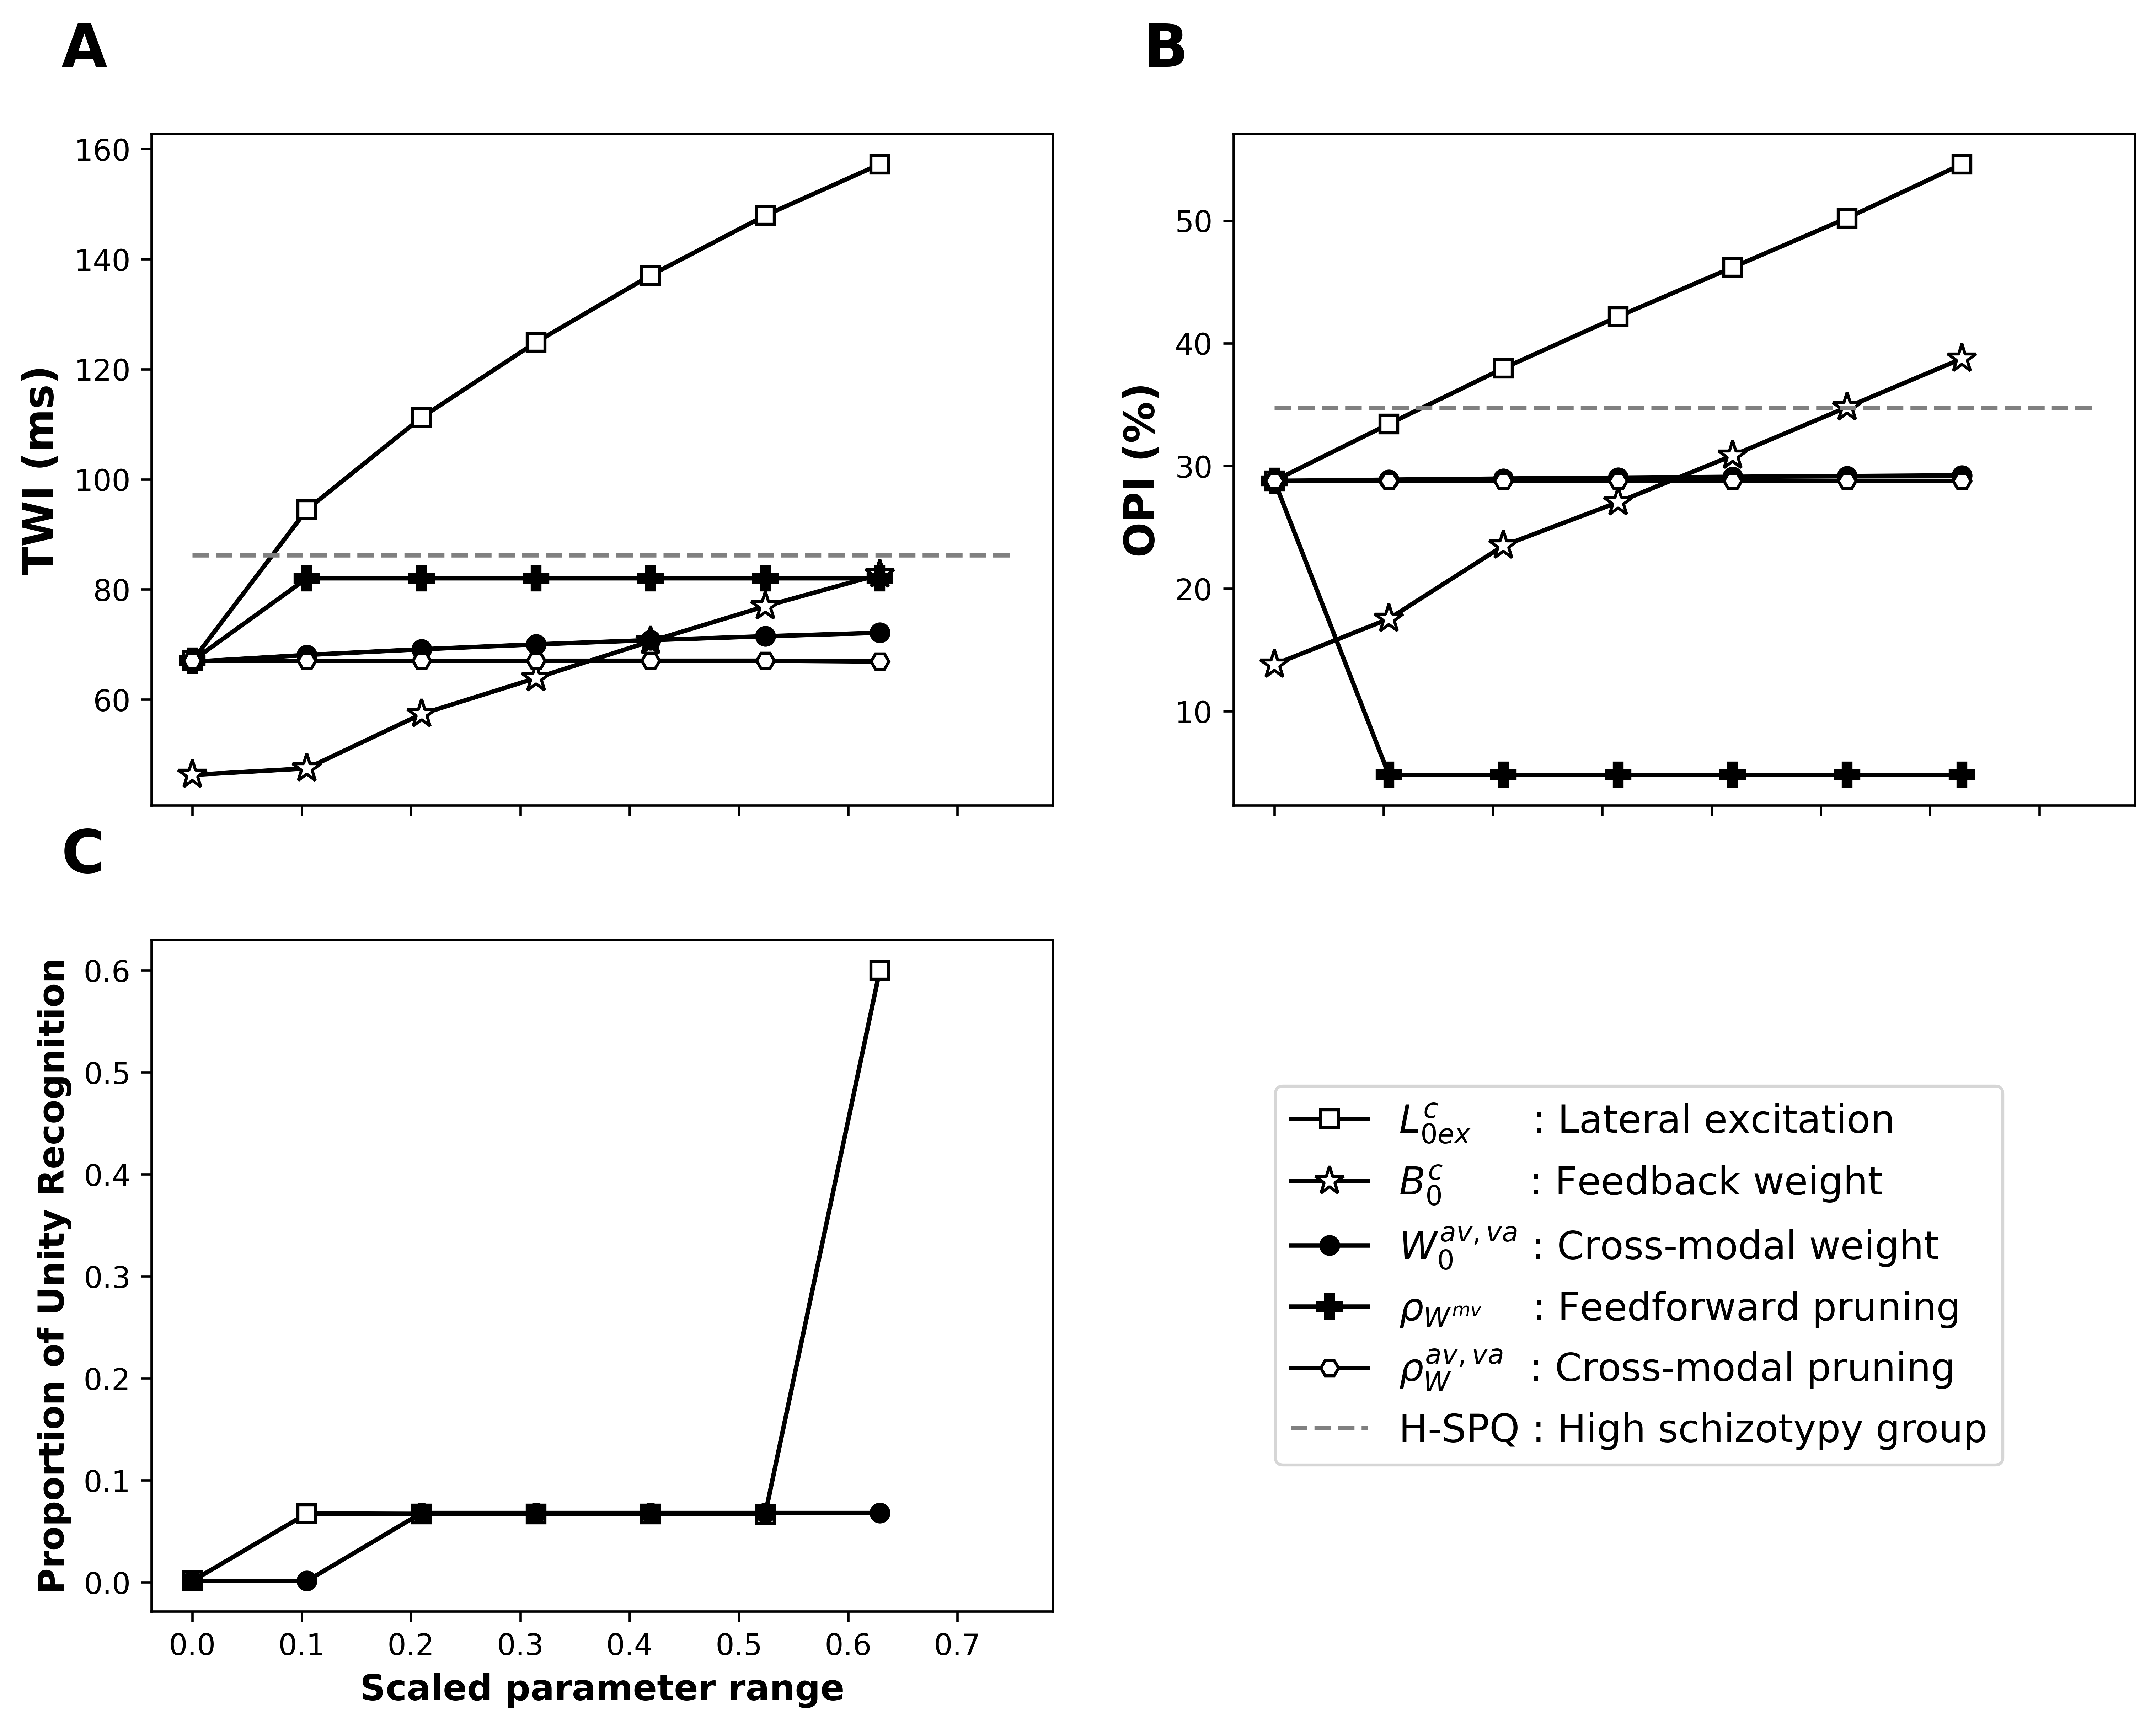

In [10]:
from sklearn.preprocessing import normalize
import string
from matplotlib import rc

norm_lex_values = normalize(lex_values.reshape(1, -1))[0]
norm_fb_weight_values = normalize(fb_weight_values.reshape(1, -1))[0]
norm_cm_weight_values = normalize(cm_weight_values.reshape(1, -1))[0]

rc("text", usetex=False)

fig, axs = plt.subplots(2, 2, figsize=(12, 9), dpi=600, sharex=True)
size = 5

ax1 = plt.subplot(221)
ax1.plot(
    norm_cm_weight_values,
    tbw_per_lex,
    label=r"$L_{0ex}^{c}$",
    color="k",
    marker="s",
    markerfacecolor="white",
)
ax1.plot(
    norm_cm_weight_values,
    tbw_per_fb_weight,
    label=r"$B_{0}^{c}$",
    color="k",
    marker="*",
    markerfacecolor="white",
    markersize=10,
)
ax1.plot(
    norm_cm_weight_values,
    tbw_per_cm_weight,
    label=r"$W_{0}^{av, va}$",
    color="k",
    marker="o",
    # markerfacecolor="white",
)

ax1.plot(
    norm_cm_weight_values,
    tbw_per_ff_pruning,
    label=r"$\rho_{{W}^{mv}}$",
    color="k",
    marker="P",
    # markerfacecolor="white",
    markersize=8,
)

ax1.plot(
    norm_cm_weight_values,
    tbw_per_cm_pruning,
    label=r"$\rho_{W}^{{av, va}}$",
    color="k",
    marker="H",
    markerfacecolor="white",
)

ax1.plot(
    np.linspace(0, 0.75, size),
    np.repeat(86.2012, size),
    "--",
    label="H-SPQ",
    color="0.5",
)
ax1.set_ylabel("TWI (ms)", size=14, weight="bold")
ax1.text(
    -0.1,
    1.1,
    string.ascii_uppercase[0],
    transform=ax1.transAxes,
    size=20,
    weight="bold",
)

ax2 = plt.subplot(222)
ax2.plot(
    norm_cm_weight_values,
    opi_per_lex,
    label=r"$L_{0ex}^{c}$     : Lateral excitation",
    color="k",
    marker="s",
    markerfacecolor="white",
)
ax2.plot(
    norm_cm_weight_values,
    opi_per_fb_weight,
    label=r"$B_{0}^{c}$       : Feedback weight",
    color="k",
    marker="*",
    markerfacecolor="white",
    markersize=10,
)
ax2.plot(
    norm_cm_weight_values,
    opi_per_cm_weight,
    label=r"$W_{0}^{av, va}$ : Cross-modal weight",
    color="k",
    marker="o",
    # markerfacecolor="white",
)

ax2.plot(
    norm_cm_weight_values,
    opi_per_ff_pruning,
    label=r"$\rho_{{W}^{mv}}$    : Feedforward pruning",
    color="k",
    marker="P",
    # markerfacecolor="white",
    markersize=8,
)

ax2.plot(
    norm_cm_weight_values,
    opi_per_cm_pruning,
    label=r"$\rho_{W}^{{av, va}}$  : Cross-modal pruning",
    color="k",
    marker="H",
    markerfacecolor="white",
)


ax2.plot(
    np.linspace(0, 0.75, size),
    np.repeat(34.71, size),
    "--",
    label="H-SPQ : High schizotypy group",
    color="0.5",
)
ax2.set_ylabel("OPI (%)", size=14, weight="bold")
leg = ax2.legend(fontsize=13, loc="center", bbox_to_anchor=(0.45, -0.7))
ax2.text(
    -0.1,
    1.1,
    string.ascii_uppercase[1],
    transform=ax2.transAxes,
    size=20,
    weight="bold",
)

ax3 = plt.subplot(223)
ax3.plot(
    norm_cm_weight_values,
    causes_per_lex,
    label=r"$L_{0ex}^{c}$",
    color="k",
    marker="s",
    markerfacecolor="white",
)

ax3.plot(
    norm_cm_weight_values,
    causes_per_cm_weight,
    label=r"$W_{0}^{av, va}$",
    color="k",
    marker="o",
    # markerfacecolor="white",
)

ax3.set_ylabel("Proportion of Unity Recognition", size=12, weight="bold")
ax3.set_xlabel("Scaled parameter range", size=12, weight="bold")
ax3.text(
    -0.1,
    1.1,
    string.ascii_uppercase[2],
    transform=ax3.transAxes,
    size=20,
    weight="bold",
)

fig.delaxes(axs.flatten()[3])


# fig.savefig("drafts/FIG3.eps", bbox_inches="tight", format="eps")